<a href="https://colab.research.google.com/github/lingmHVAC/lingmHVAC/blob/main/ThreePointMomentCalibration_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fitted Jin = 5.344 #/cm3/s
Fitted K   = 5.14e-29 cm3/s


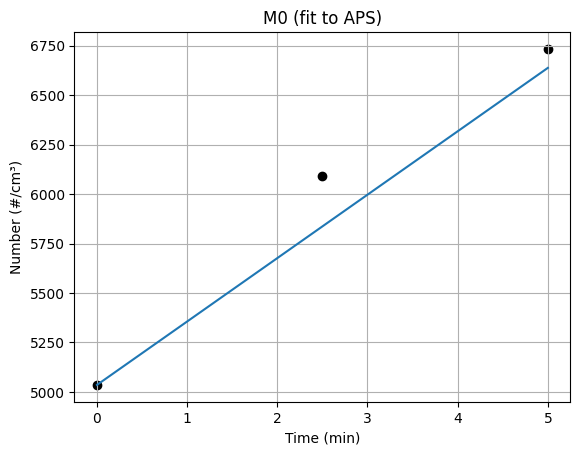

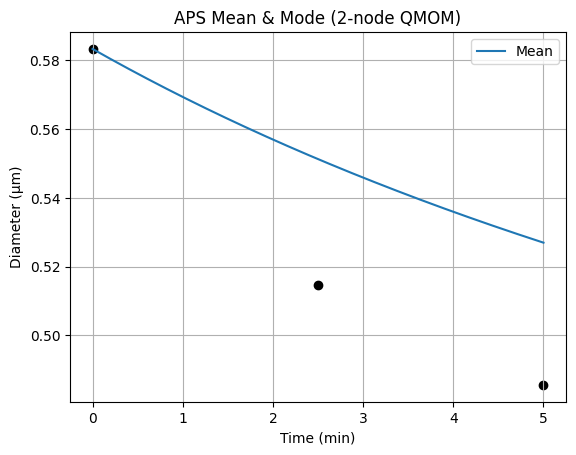

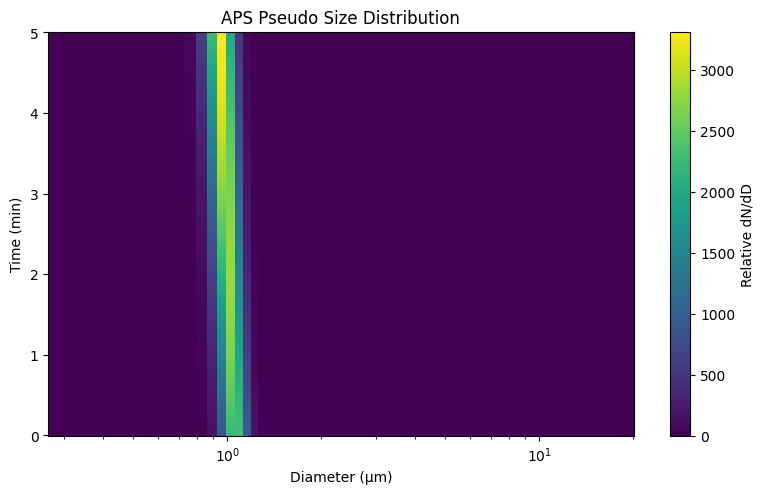

In [2]:
# coagulation and injection, no condensation
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares
import matplotlib.pyplot as plt

# ============================================================
# MEASURED MOMENTS (APS)
# ============================================================
t_data = np.array([0.0, 150.0, 300.0])  # seconds

M_data = np.array([
    [5035, 2937, 2860, 8382],
    [6091, 3135, 2553, 7743],
    [6734, 3270, 2438, 8130]
])

din = 0.35  # µm (sub-APS injection size)

# ============================================================
# MOMENT MODEL
# ============================================================
def moment_rhs(t, y, Jin, K):
    M0, M1, M2, M3 = y
    return [
        Jin - 0.5 * K * M0**2,
        Jin * din,
        Jin * din**2 + K * M1**2,
        Jin * din**3 + 3 * K * M1 * M2
    ]

# ============================================================
# OBJECTIVE FUNCTION
# ============================================================
def residuals(params):
    Jin, K = params
    sol = solve_ivp(
        lambda t, y: moment_rhs(t, y, Jin, K),
        [0, t_data[-1]],
        M_data[0],
        t_eval=t_data,
        rtol=1e-8
    )
    return (sol.y.T - M_data).ravel()

# ============================================================
# FIT Jin and K
# ============================================================
guess = [6.0, 3e-10]
bounds = ([0.0, 0.0], [50.0, 1e-8])

res = least_squares(residuals, guess, bounds=bounds)

Jin_fit, K_fit = res.x
print(f"Fitted Jin = {Jin_fit:.3f} #/cm3/s")
print(f"Fitted K   = {K_fit:.2e} cm3/s")

# ============================================================
# INTEGRATE FULL TRAJECTORY
# ============================================================
t_eval = np.linspace(0, 300, 300)
sol = solve_ivp(
    lambda t, y: moment_rhs(t, y, Jin_fit, K_fit),
    [0, 300],
    M_data[0],
    t_eval=t_eval
)

M0, M1, M2, M3 = sol.y

# ============================================================
# 2-NODE QMOM RECONSTRUCTION
# ============================================================
mean_d = M1 / M0
var = M2 / M0 - mean_d**2
std = np.sqrt(np.maximum(var, 1e-12))

d1 = mean_d - std
d2 = mean_d + std
w1 = 0.5 * M0
w2 = 0.5 * M0

mode = np.where(w1 * d1 > w2 * d2, d1, d2)

# ============================================================
# PSEUDO APS DISTRIBUTION
# ============================================================
Dgrid = np.linspace(0.3, 20.0, 300)
pdf = np.zeros((len(t_eval), len(Dgrid)))

for i in range(len(t_eval)):
    pdf[i] = (
        w1[i] * np.exp(-(Dgrid - d1[i])**2 / (2*0.03**2)) +
        w2[i] * np.exp(-(Dgrid - d2[i])**2 / (2*0.07**2))
    )

# ============================================================
# PLOTS
# ============================================================
plt.figure()
plt.plot(t_eval/60, M0)
plt.scatter(t_data/60, M_data[:,0], color='k')
plt.xlabel("Time (min)")
plt.ylabel("Number (#/cm³)")
plt.title("M0 (fit to APS)")
plt.grid()

plt.figure()
plt.plot(t_eval/60, mean_d, label="Mean")
#plt.plot(t_eval/60, mode, '--', label="Mode")
plt.scatter(t_data/60, M_data[:,1]/M_data[:,0], color='k')
plt.xlabel("Time (min)")
plt.ylabel("Diameter (µm)")
plt.legend()
plt.title("APS Mean & Mode (2-node QMOM)")
plt.grid()


plt.figure(figsize=(8,5))
plt.pcolormesh(Dgrid, t_eval/60, pdf, shading='auto')
plt.xlabel("Diameter (µm)")
plt.ylabel("Time (min)")
plt.title("APS Pseudo Size Distribution")
plt.colorbar(label="Relative dN/dD")
plt.tight_layout()
plt.xscale('log')
plt.show()

np.savetxt('data.csv', (t_eval/60, M0, mean_d), delimiter=',')